In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from functions.naming import rename_columns

# Load your dataset
# Assuming your data is stored in a CSV file named 'your_data.csv'
df = pd.read_excel("/Users/athanasioskaravangelis/Desktop/RSM BAM/Workshop/pko_forecasting/data/PKO_Initial_Dataset.xlsx")
#rename columns
df = rename_columns(df)
# select only the values after 2010-01-01
df['date'] = pd.to_datetime(df['date'], format='%b-%y')
df = df[df['date'] > '2009-12-02']
df = df[df['date'] < '2023-11-02']

# Check for missing values
missing_values = df.isnull().sum()

In [125]:
# drop soybean_oil_zlz2 and jet_fuel_us_usd_mt
df = df.drop(['soybean_oil_zlz2'], axis=1)
df = df.drop(['jet_fuel_us_usd_mt'], axis=1)
# Handle missing values (e.g., impute with mean)
df.fillna(df.mean(), inplace=True)

In [126]:
df.columns

Index(['ONI', 'Precipitation_Indonesia', 'Precipitation_Malaysia',
       'Temperaturemin_Indonesia', 'Temperaturemin_Malaysia',
       'Temperaturemax_Indonesia', 'Temperaturemax_Malaysia',
       'Humidex_Indonesia', 'Humidex_Malaysia', 'date', 'pko_fob_malaysia',
       'pko_cif_rotterdam', 'coconut_cif_rotterdam', 'palm_oil_cif_nwe',
       'palm_olein_fob_malaysia', 'palm_stearin_cif_rotterdam',
       'tallow_fob_us_gulf', 'bio_ethanol', 'fatty_alcohol_c12_14_fob_asia',
       'fatty_alcohol_c16_18_fob_asia', 'fatty_alcohol_c12_14_fd_nwe', 'rspo',
       'jet_fuel_europe', 'jet_fuel_us', 'ukraine_war', 'malaysia_harvest',
       'malaysia_disaster', 'indonesia_disaster', 'indonesia_harvest',
       'myr_usd_rate', 'idr_usd_rate', 'palm_oil_harvest_area_indonesia',
       'palm_oil_production_indonesia', 'pko_production_indonesia',
       'palm_oil_harvest_area_malaysia', 'palm_oil_production_malaysia',
       'pko_production_malaysia', 'pko_monthly_stocks_indonesia',
       'pko_

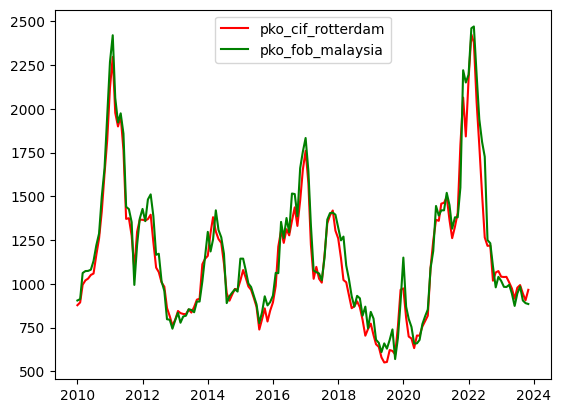

In [127]:
# plot pko_cif_rotterdam and pko_fob_malaysia with x-axis the date
plt.plot(df['date'], df['pko_cif_rotterdam'], label='pko_cif_rotterdam', color='red')
plt.plot(df['date'], df['pko_fob_malaysia'], label='pko_fob_malaysia', color='green')
plt.legend()
plt.show()

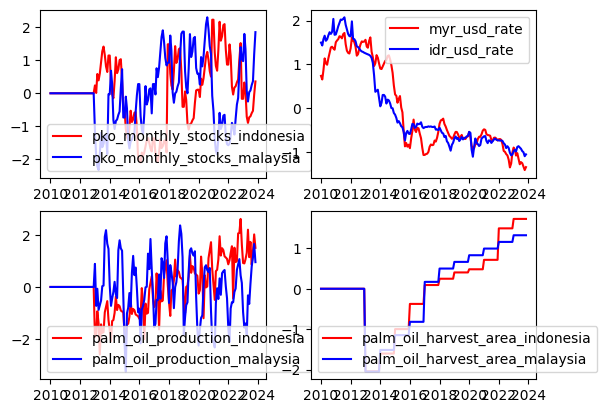

In [128]:
# plot in 4 plots in a square 
# 1: pko_monthly_stocks_indonesia, pko_monthly_stocks_malaysia 
# 2: myr_usd_rate, idr_usd_rate with x-axis the date
# 3: palm_oil_production_indonesia, palm_oil_production_malaysia with x-axis the date
# 4: palm_oil_harvest_area_indonesia, palm_oil_harvest_area_malaysia with x-axis the date

# normalize the data first
df_norm = df.copy()
df_norm = df_norm.drop(['date'], axis=1)
df_norm = (df_norm - df_norm.mean()) / df_norm.std()

# plot the four plots in a square with plt
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(df['date'], df_norm['pko_monthly_stocks_indonesia'], label='pko_monthly_stocks_indonesia', color='red')
axs[0, 0].plot(df['date'], df_norm['pko_monthly_stocks_malaysia'], label='pko_monthly_stocks_malaysia', color='blue')
axs[0, 0].legend()
axs[0, 1].plot(df['date'], df_norm['myr_usd_rate'], label='myr_usd_rate', color='red')
axs[0, 1].plot(df['date'], df_norm['idr_usd_rate'], label='idr_usd_rate', color='blue')
axs[0, 1].legend()
axs[1, 0].plot(df['date'], df_norm['palm_oil_production_indonesia'], label='palm_oil_production_indonesia', color='red')
axs[1, 0].plot(df['date'], df_norm['palm_oil_production_malaysia'], label='palm_oil_production_malaysia', color='blue')
axs[1, 0].legend()
axs[1, 1].plot(df['date'], df_norm['palm_oil_harvest_area_indonesia'], label='palm_oil_harvest_area_indonesia', color='red')
axs[1, 1].plot(df['date'], df_norm['palm_oil_harvest_area_malaysia'], label='palm_oil_harvest_area_malaysia', color='blue')
axs[1, 1].legend()
plt.show()

## Time series decomposition

In [ ]:
date_col = 'date'  # Replace with the actual date column name
df[date_col] = pd.to_datetime(df[date_col])
df.set_index(date_col, inplace=True)

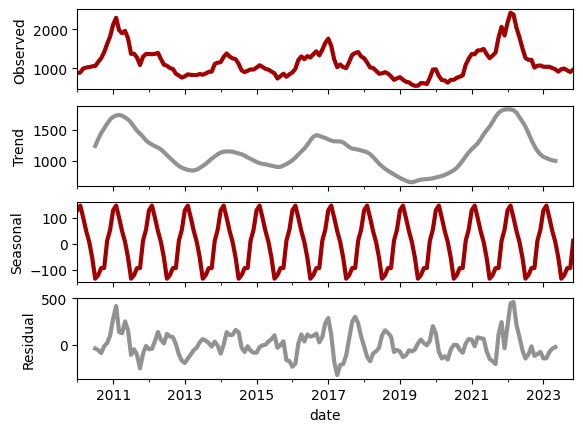

In [130]:
# Time Series Decomposition
result = seasonal_decompose(df['pko_cif_rotterdam'], model='additive')
fig, axes = plt.subplots(4, 1, sharex=True)

# make line thicker
plt.rcParams['lines.linewidth'] = 3
result.observed.plot(ax=axes[0], legend=False, color='#A20000')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color='#929292')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, color='#A20000')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color='#929292')
axes[3].set_ylabel('Residual')
plt.show()

In [104]:
# Feature Selection
from sklearn.preprocessing import MinMaxScaler


X = df.drop(['pko_cif_rotterdam', 'pko_fob_malaysia', 'palm_olein_fob_malaysia', 'fatty_alcohol_c12_14_fob_asia',
             'palm_stearin_cif_rotterdam', 'palm_oil_cif_nwe', 'fatty_alcohol_c12_14_fd_nwe', 'fatty_alcohol_c16_18_fob_asia',
             'tallow_fob_us_gulf', 'jet_fuel_europe', 'jet_fuel_us', 'coconut_cif_rotterdam'],axis=1)
y = df['pko_cif_rotterdam']

scaler = MinMaxScaler()
X2 = scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y2 = y_scaler.fit_transform(y.values.reshape(-1, 1))

#make X a dataframe again
#i want to reshape the array to a dataframe
X3 = pd.DataFrame(X2, columns=X.columns)

# Using Random Forest for feature importance
rf_model = RandomForestRegressor()
rf_model.fit(X, y2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [105]:
# see results of feature importance in a dataframe with 2 columns -> feature_name, importance
feature_imp = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns)), columns=['Value', 'Feature'])
# sort values in descending order
feature_imp.sort_values(by='Value', ascending=False, inplace=True)
feature_imp


,Value,Feature
37,0.212557,ONI
36,0.191136,idr_usd_rate
35,0.069537,pmi_malaysia
34,0.055255,bio_ethanol
33,0.051933,pko_production_malaysia
32,0.043965,pko_monthly_stocks_malaysia
31,0.032954,myr_usd_rate
30,0.032172,pko_monthly_stocks_indonesia
29,0.022620,pmi_indonesia
28,0.022069,Temperaturemax_Malaysia


/var/folders/35/tbpcvh252s9dy7dhvwv499800000gn/T/ipykernel_2258/3771513159.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


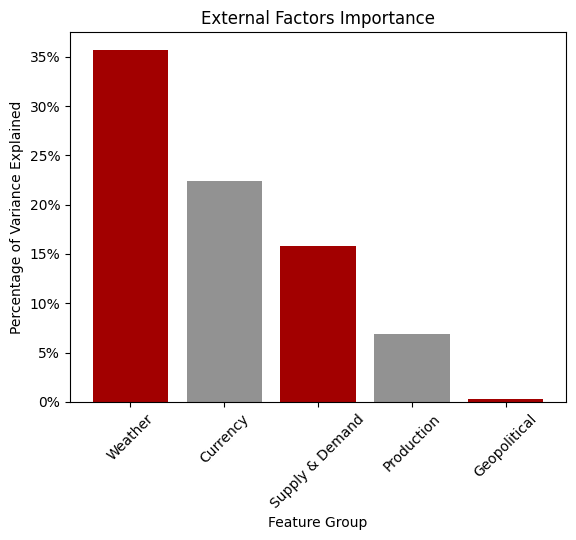

In [112]:
# group weather feature importances -> ONI, Temperaturemin_Malaysia, Temperaturemax_Indonesia, Temperaturemax_Malaysia, Temperaturemin_Indonesia, Humidex_Malaysia, Humidex_Indonesia, Precipitation_Indonesia, Precipitation_Malaysia
weather_feature_imp = feature_imp[feature_imp['Feature'].str.contains('ONI|Temperaturemin_Malaysia|Temperaturemax_Indonesia|Temperaturemax_Malaysia|Temperaturemin_Indonesia|Humidex_Malaysia|Humidex_Indonesia|Precipitation_Indonesia|Precipitation_Malaysia')]
# calculate the sum of the feature importances
weather_feature_imp_sum = weather_feature_imp['Value'].sum()

# group currency feature importances -> myr_usd_rate, idr_usd_rate
currency_feature_imp = feature_imp[feature_imp['Feature'].str.contains('myr_usd_rate|idr_usd_rate')]
# calculate the sum of the feature importances
currency_feature_imp_sum = currency_feature_imp['Value'].sum()

#group supply and demand
supply_demand_feature_imp = feature_imp[feature_imp['Feature'].str.contains('pko_monthly_stocks_indonesia|pko_monthly_stocks_malaysia|palm_oil_production_indonesia|palm_oil_production_malaysia|palm_oil_harvest_area_indonesia|palm_oil_harvest_area_malaysia|pko_domestic_consumption_indonesia|pko_domestic_consumption_malaysia|pko_exports_indonesia|pko_exports_malaysia')]
# calculate the sum of the feature importances
supply_demand_feature_imp_sum = supply_demand_feature_imp['Value'].sum()

# group production
production_feature_imp = feature_imp[feature_imp['Feature'].str.contains('palm_oil_production_indonesia|palm_oil_production_malaysia| pko_production_indonesia|pko_production_malaysia')]
# calculate the sum of the feature importances
production_feature_imp_sum = production_feature_imp['Value'].sum()

# group geopolitical variables 
geopolitical_feature_imp = feature_imp[feature_imp['Feature'].str.contains('ukraine_war|mspo_certification|cpopc_mal_ind_2015|ispo_certification')]
# calculate the sum of the feature importances
geopolitical_feature_imp_sum = geopolitical_feature_imp['Value'].sum()

# plot these in a bar chart now
# create a list of labels
labels = ['Weather', 'Currency', 'Supply & Demand', 'Production', 'Geopolitical']
# create a list of the values multi[lie by 100 to get percentages]
values = [weather_feature_imp_sum*100, currency_feature_imp_sum*100, supply_demand_feature_imp_sum*100, production_feature_imp_sum*100, geopolitical_feature_imp_sum*100]
# plot the bar chart
# make x-axis 45 degrees
# make the y-axis to be percentages
plt.xticks(rotation=45)
# make colors be from color='#A20000' to scolor='#929292' one after the other
colors = ['#A20000', '#929292', '#A20000', '#929292', '#A20000']
# plot the bar chart
plt.bar(labels, values, color=colors)
plt.xlabel('Feature Group')
# make y axis labels to be percentages with the '%' after the number
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.ylabel('Percentage of Variance Explained')
plt.title('External Factors Importance')
plt.show()


In [115]:
# Select relevant features based on importance
sfm = SelectFromModel(rf_model, threshold=0.005)
sfm.fit(X, y)
selected_features = X.columns[sfm.get_support()]

# Data Splitting
# Assuming you want to split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Display results
print("Selected Features:", selected_features)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Selected Features: Index(['ONI', 'Precipitation_Indonesia', 'Precipitation_Malaysia',
       'Temperaturemin_Indonesia', 'Temperaturemin_Malaysia',
       'Temperaturemax_Indonesia', 'Temperaturemax_Malaysia',
       'Humidex_Indonesia', 'Humidex_Malaysia', 'bio_ethanol', 'rspo',
       'malaysia_harvest', 'myr_usd_rate', 'idr_usd_rate',
       'pko_production_indonesia', 'palm_oil_harvest_area_malaysia',
       'palm_oil_production_malaysia', 'pko_production_malaysia',
       'pko_monthly_stocks_indonesia', 'pko_monthly_stocks_malaysia',
       'pko_domestic_consumption_malaysia', 'pko_exports_indonesia',
       'pko_exports_malaysia', 'pko_total_supply_indonesia', 'pmi_indonesia',
       'pmi_malaysia'],
      dtype='object')
Training set shape: (133, 38) (133,)
Testing set shape: (34, 38) (34,)
